In [1]:
import numpy as np

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.cross_validation import StratifiedKFold
from scipy.io import wavfile
import wave
import glob
import csv

import librosa
import librosa.display
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

%matplotlib inline
matplotlib.style.use('ggplot')

/home/abhishek/anaconda3/envs/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
'''
Reading train and test class labels of the dataset from csv file.
If we get a json file, we can easily convert it to csv and then proceed. 
'''
train = pd.read_csv("whales_classlabel.csv")
# test = pd.read_csv("whales_test.csv")

In [3]:
'''
We reduce the number of negative examples here so as to balance out the whole dataset. The other method would be 
to augment the minority classes
'''
train.head()

,fname,label
0,neg_00.wav,Negative
1,neg_01.wav,Negative
2,neg_02.wav,Negative
3,neg_03.wav,Negative
4,neg_04.wav,Negative


In [4]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))

Number of training examples= 25   Number of classes= 9


In [5]:
print(train.label.unique())

['Negative' 'weeya' 'double weeya' 'a' 'updownup' 'richochet' 'c' 'b'
 'swoop']


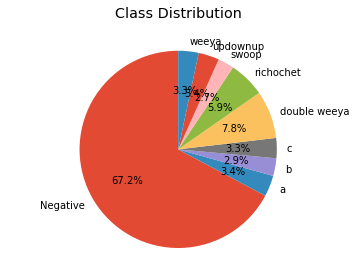

,fname,label,length
0,neg_00.wav,Negative,0.511361
1,neg_01.wav,Negative,20.114286
2,neg_02.wav,Negative,15.646576
3,neg_03.wav,Negative,150.204082
4,neg_04.wav,Negative,0.417574
5,neg_05.wav,Negative,11.023673
6,pos_00.wav,weeya,2.706961
7,pos_01.wav,double weeya,3.850567
8,pos_02.wav,weeya,0.981270
9,pos_03.wav,weeya,1.760703


In [6]:
df = pd.read_csv('whales_classlabel.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('data_labels/' + f)
    #print(rate)
    df.at[f, 'length'] = signal.shape[0]/rate
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels = class_dist.index, autopct='%1.1f%%',
    shadow=False, startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=False)

In [7]:
'''
We observe that:

The number of audio samples per category is non-uniform. The minimum number of audio samples in a category 
is 1 while the maximum is 6
'''

print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  1
Maximum samples per category =  6


In [8]:
'''
We see that different samples have different durations of audio
'''
wav_list = glob.glob('data_labels/*.wav')
#fname = 'data_labels/neg_00.wav'
l = []
for i in range(len(wav_list)):
    wav = wave.open(wav_list[i])
#     print(wav_list[i])
    l.append([wav_list[i][12:], wav.getframerate(), wav.getnframes(), wav.getnframes()/wav.getframerate()])
print("File  ", "Sampling Rate  ", "Total Samples  ", "Duration(s) " )
for dat in l:
    print(*dat)

File   Sampling Rate   Total Samples   Duration(s) 
pos_18.wav 44100 90446 2.0509297052154194
pos_04.wav 44100 63223 1.4336281179138322
pos_13.wav 44100 57698 1.308344671201814
pos_01.wav 44100 169810 3.8505668934240362
pos_10.wav 44100 67072 1.5209070294784581
pos_05.wav 44100 82177 1.8634240362811791
pos_07.wav 44100 56250 1.2755102040816326
pos_00.wav 44100 119377 2.7069614512471656
pos_06.wav 44100 67328 1.5267120181405895
pos_12.wav 44100 62719 1.4221995464852608
pos_11.wav 44100 71424 1.619591836734694
neg_04.wav 44100 18415 0.41757369614512474
pos_03.wav 44100 77647 1.760702947845805
pos_08.wav 44100 79236 1.796734693877551
pos_15.wav 44100 81310 1.8437641723356009
pos_02.wav 44100 43274 0.9812698412698413
pos_14.wav 44100 80640 1.8285714285714285
pos_09.wav 44100 247988 5.623310657596372
neg_00.wav 44100 22551 0.5113605442176871
pos_17.wav 44100 57437 1.3024263038548753
neg_01.wav 44100 887040 20.114285714285714
neg_05.wav 44100 486144 11.023673469387756
neg_02.wav 44100 690014

In [9]:
fname = 'data_labels/pos_14.wav'
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (80640,)
[-3204 -3864 -3765 ...   682  2186  1448]


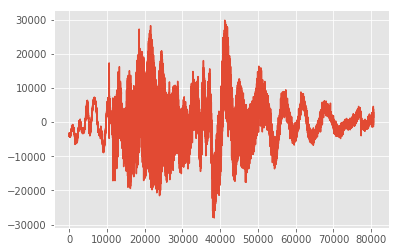

In [10]:
plt.plot(data, '-', );

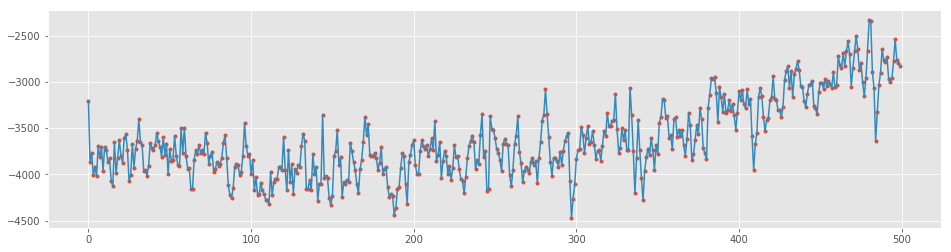

In [11]:
# Looking at first 500 frames

plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

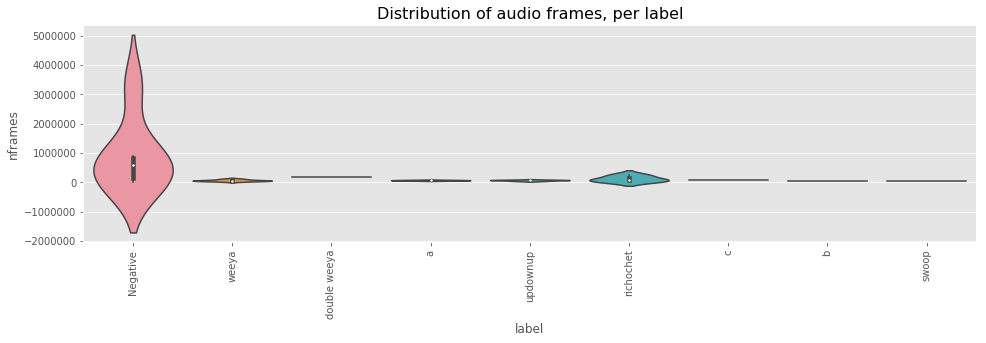

In [12]:
'''
We see that the distribution of audio length across labels is non-uniform and has very high variance
'''
train['nframes'] = train['fname'].apply(lambda f: wave.open('data_labels/' + f).getnframes())
# test['nframes'] = test['fname'].apply(lambda f: wave.open('data_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train, scale='width')
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

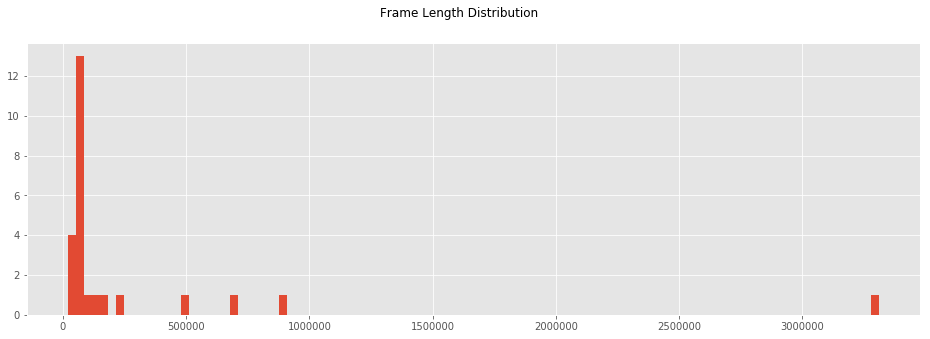

In [13]:
'''
Majority of the audio files are short and there exist an outlier as seen below.
'''
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
train.nframes.hist(bins=100, ax=axes)
plt.suptitle('Frame Length Distribution', ha='center', fontsize='large');

In [14]:
file_path = 'data_labels/pos_10.wav'
data, sr = librosa.core.load(file_path, sr=44100,
                                        res_type='kaiser_fast')

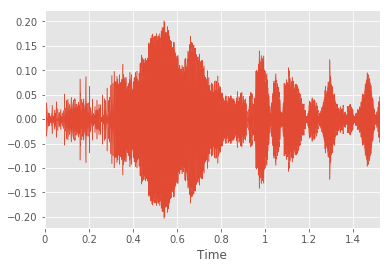

In [15]:
librosa.display.waveplot(data, sr=sr)

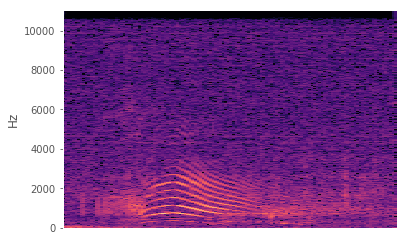

In [16]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')

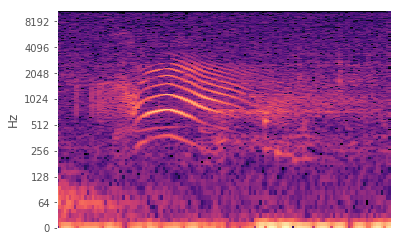

In [17]:
librosa.display.specshow(D, y_axis='log')

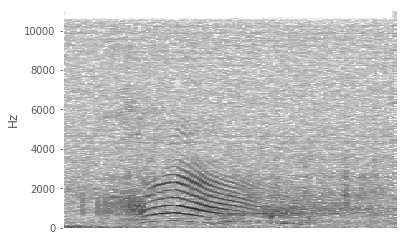

In [18]:
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')

In [19]:
sampling_rate = 16000
audio_duration = 4
use_mfcc = False
n_mfcc = 20
audio_length = sampling_rate * audio_duration
preprocessing_fn = lambda x: x

input_length = audio_length
#print(input_length)

# Random offset / Padding
if len(data) > input_length:
    max_offset = len(data) - input_length
    offset = np.random.randint(max_offset)
    data = data[offset:(input_length+offset)]
else:
    if input_length > len(data):
        max_offset = input_length - len(data)
        offset = np.random.randint(max_offset)
    else:
        offset = 0
    data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
print(data.shape)
# Normalization + Other Preprocessing
if use_mfcc:
    data = librosa.feature.mfcc(data, sr=sampling_rate,
                                       n_mfcc=n_mfcc)
    data = np.expand_dims(data, axis=-1)
else:
    data = preprocessing_fn(data)[:, np.newaxis]

(64000,)


In [20]:
data

array([[0.02496338],
       [0.02941895],
       [0.03137207],
       ...,
       [0.05508423],
       [0.05465698],
       [0.04769897]], dtype=float32)

/home/abhishek/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


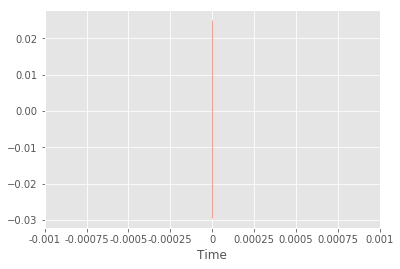

In [21]:
librosa.display.waveplot(data, sr=sr)

In [22]:
librosa.display.cmap(data)

In [23]:
SAMPLE_RATE = 44100
wav, _ = librosa.core.load(file_path, sr=SAMPLE_RATE)
#wav = wav[:2*44100]

In [24]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=20)
mfcc.shape

(20, 132)

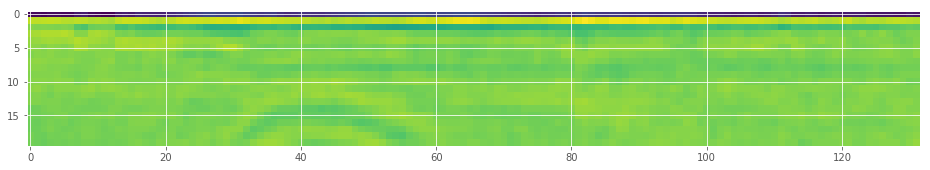

In [25]:
plt.figure(figsize=(16, 14))
plt.imshow(mfcc);

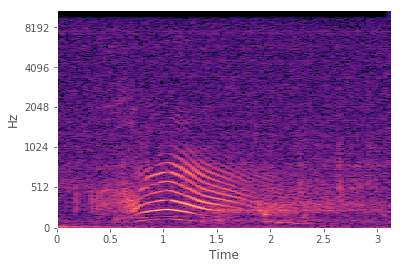

In [26]:
D = np.abs(librosa.stft(wav, n_fft=2048, win_length=2000, hop_length=500))
librosa.display.specshow(librosa.amplitude_to_db(D, ref = np.max),y_axis='mel', x_axis='time')

In [79]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5


In [80]:
file_path = 'data_labels/pos_14.wav'
data, sr = librosa.core.load(file_path, sr=44100,
                                        res_type='kaiser_fast')

In [92]:
file_path = 'data_labels/pos_15.wav'
dataa, sr = librosa.core.load(file_path, sr=44100,
                                        res_type='kaiser_fast')
dataa_norm = audio_norm(dataa)

In [88]:
data_norm = audio_norm(data)

In [55]:
sampling_rate = 16000
audio_duration = 3
use_mfcc = False
n_mfcc = 20
audio_length = sampling_rate * audio_duration
preprocessing_fn = lambda x: x

input_length = audio_length
print(input_length)
print(len(data))

# Random offset / Padding
if len(data) > input_length:
    max_offset = len(data) - input_length
    offset = np.random.randint(max_offset)
    data = data[offset:(input_length+offset)]
else:
    if input_length > len(data):
        max_offset = input_length - len(data)
        offset = np.random.randint(max_offset)
    else:
        offset = 0
    data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

# data = librosa.feature.mfcc(data, sr=sampling_rate,
#                                                    n_mfcc=n_mfcc)
# data = np.expand_dims(data, axis=-1)

48000
80640


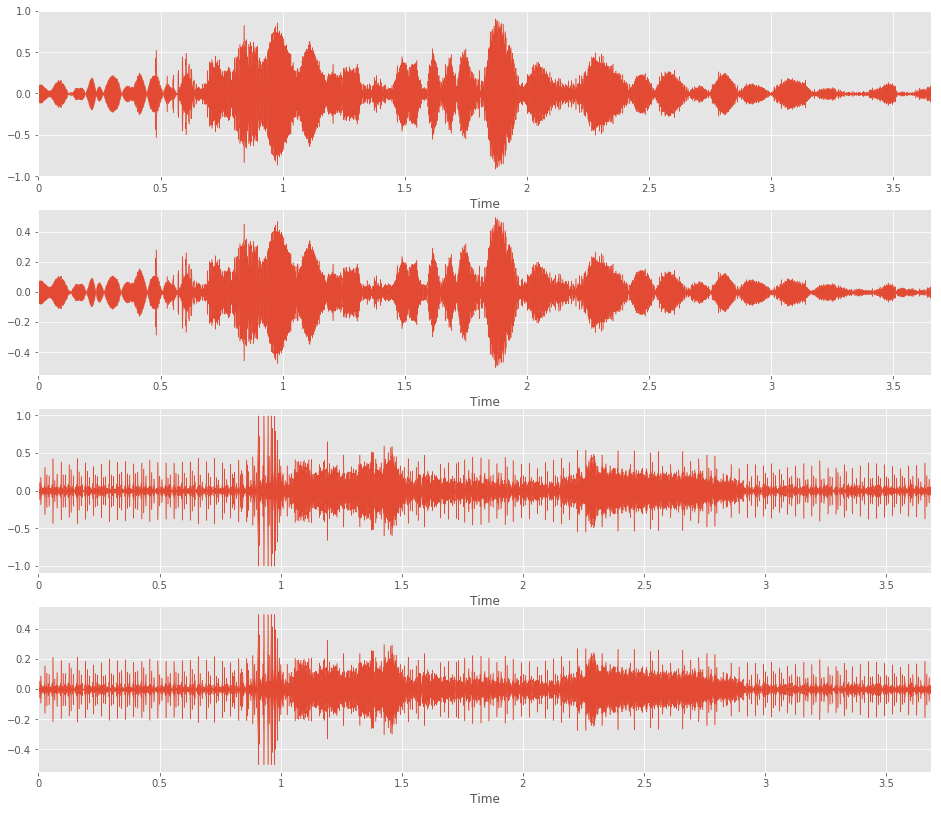

In [93]:
plt.figure(figsize=(16, 14))
plt.subplot(4,1,1)
librosa.display.waveplot(data)
plt.subplot(4,1,2)
librosa.display.waveplot(data_norm)
plt.subplot(4,1,3)
librosa.display.waveplot(dataa)
plt.subplot(4,1,4)
librosa.display.waveplot(dataa_norm)

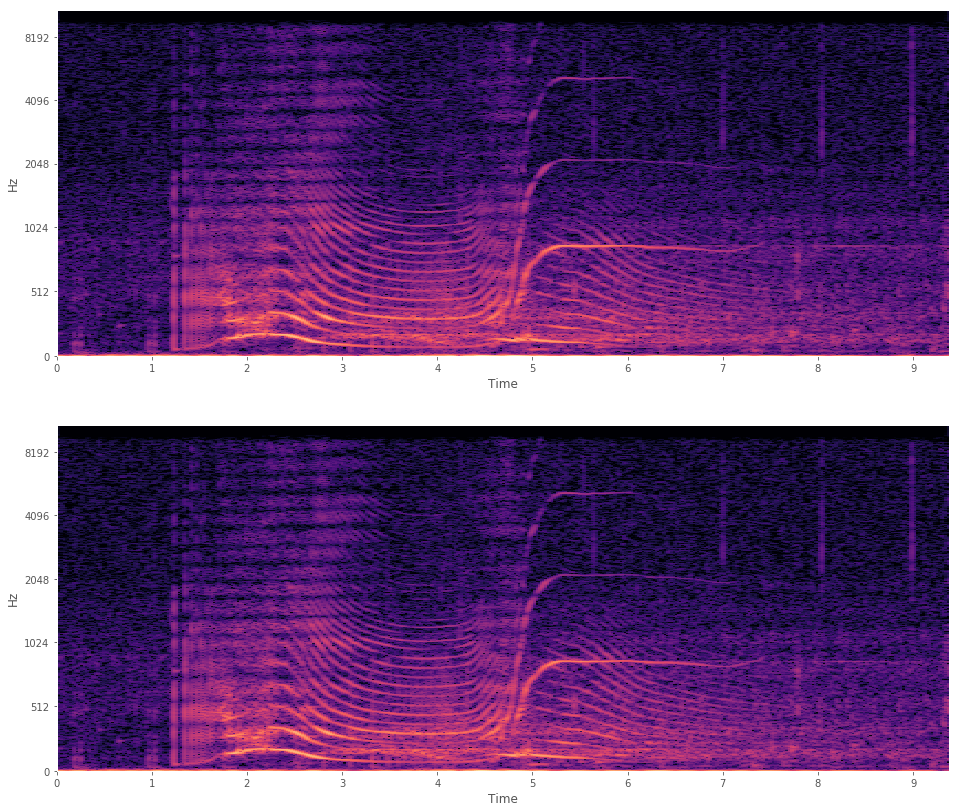

In [74]:
plt.figure(figsize=(16, 14))
D1 = np.abs(librosa.stft(data, n_fft=1024, win_length=1024, hop_length=200))
plt.subplot(2,1,1)
librosa.display.specshow(librosa.amplitude_to_db(D1, ref = np.max),y_axis='mel', x_axis='time')
D2 = np.abs(librosa.stft(data_norm, n_fft=1024, win_length=1024, hop_length=200))
plt.subplot(2,1,2)
librosa.display.specshow(librosa.amplitude_to_db(D2, ref = np.max),y_axis='mel', x_axis='time')